In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
main_page = 'http://www.angelfire.com/wa/adf/transcripts.html'
main = requests.get(main_page)
soup = BeautifulSoup(main.content, 'html.parser')
links = [x['href'] for x  in soup.body.findAll('a') if len(x['href']) == 8]

In [3]:
df_full = pd.DataFrame()
df_full_lines = pd.DataFrame()

for i in range(len(links)):
    page = requests.get('http://www.angelfire.com/wa/adf/' + links[i])
    soup = BeautifulSoup(page.content, 'html.parser')
    script = soup.body.findAll('p')
    script = [re.sub('[\r\n\xa0]', '', x.text) for x in script]
    script = [re.sub('(\s\s)+', ' ', x).strip() for x in script]
    dialogue = [1 if re.match('[A-Z][a-z]+ - ', x) else 0 for x in script]
    speaker = [re.match('[A-Z][a-z]+ - ', x).group(0)[:-3] if re.match('[A-Z][a-z]+ - ', x) else None for x in script]
    df = pd.DataFrame({'speaker' : speaker, 'script' : script, 'dialogue' : dialogue})
    for i in range(len(df)):
        if df['dialogue'][i] == 1:
            df['script'][i] = df['script'][i][len(df['speaker'][i]) + 3:]
    persons = df['speaker'].unique()[1:]
    lines = [len(df[df['speaker'] == x]) for x in persons]
    df_speaking_lines= pd.DataFrame({'person' : persons, 'lines' : lines}).sort_values('lines', ascending = False).reset_index(drop = True)
    
    df_full = pd.concat([df, df_full])
    df_full_lines = pd.concat([df_speaking_lines, df_full_lines])

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [4]:
df_full.reset_index(drop = True, inplace = True)

In [6]:
df_full['wordCount'] = [None] * len(df_full)
for i in range(len(df_full)):
    example = re.sub('[-,"!.]', '', df_full['script'][i])
    df_full['wordCount'][i] = len(re.sub('(\s\s+)', ' ', example).split())

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


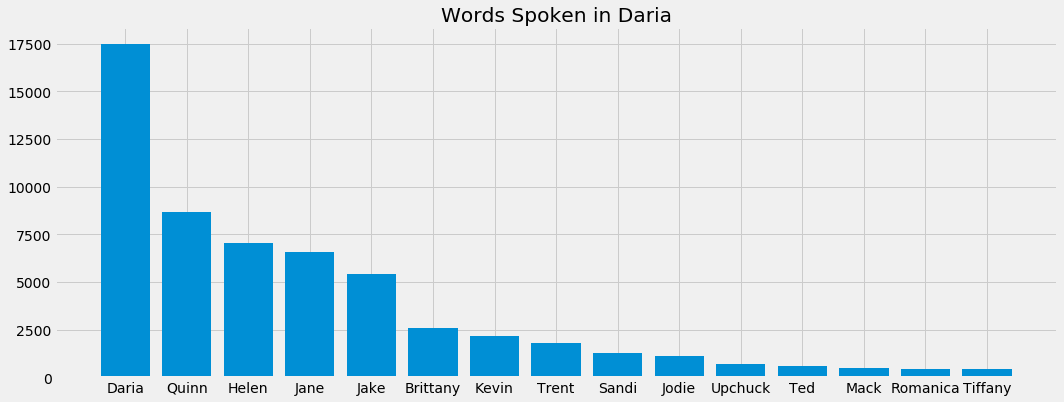

In [7]:
df_words = df_full[['speaker', 'wordCount']].groupby('speaker').sum()

df_words = df_words.sort_values('wordCount', ascending = False)

plt.style.use('fivethirtyeight')
plt.figure(figsize = (16,6))
plt.bar(x = df_words.index[:15], height = df_words['wordCount'][:15])
plt.title('Words Spoken in Daria');

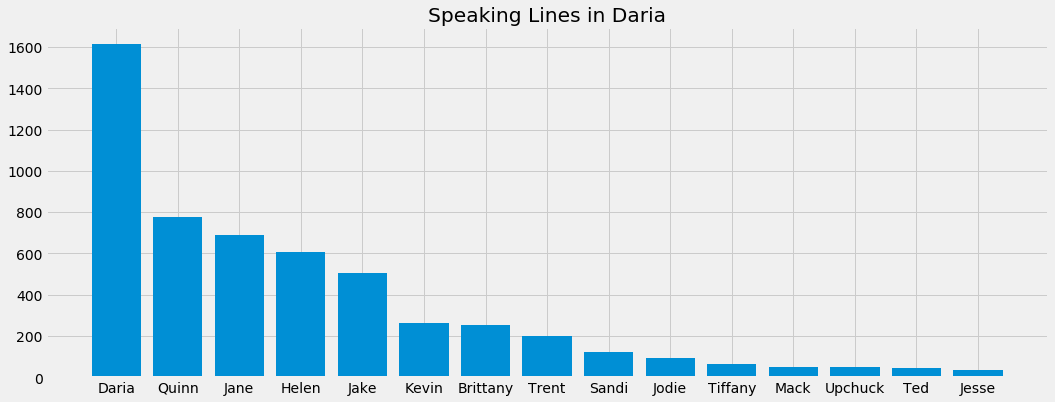

In [8]:
df_full_lines = df_full_lines.groupby('person').sum()
df_full_lines.sort_values('lines', ascending = False, inplace = True)

plt.style.use('fivethirtyeight')
plt.figure(figsize = (16,6))
plt.bar(x = df_full_lines.index[:15], height = df_full_lines['lines'][:15])
plt.title('Speaking Lines in Daria');